In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
batch='SWISS_19-35'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_SW19-35-150_10-10.npy', allow_pickle=True).item()

In [4]:
# removed key corresponding to SW21_Fam
dict_results_across_mice.pop('SW21_Fam')

,area,n_cells,energy
0,Frontal pole cerebral cortex,1,2046.343191
1,Primary motor area,13,2960.748475
2,Secondary motor area,56,11919.272323
3,Primary somatosensory area,39,4692.212991
4,Supplemental somatosensory area,0,0.000000
...,...,...,...
293,Flocculus,0,0.000000
294,Fastigial nucleus,1,4851.227957
295,Interposed nucleus,27,74158.872116
296,Dentate nucleus,0,0.000000


In [5]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

# Format data for task PLS

In [6]:
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch+'-150_10-10', table='n_cells')
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch+'-150_10-10', table='energy')

In [7]:
data_ncells = pd.read_csv('./results_pls/'+batch+'-150_10-10_n_cells.csv')
data_energy = pd.read_csv('./results_pls/'+batch+'-150_10-10_energy.csv')

In [8]:
df_levels = upls.create_df_levels(volumes)

# Apply task PLS for all areas and energy

In [9]:
%%bash
python area_pls.py -i results_pls/SWISS_19-35-150_10-10_n_cells.csv -o './results_pls/SWISS_19-35-150_10-10'

2023-05-18 17:00:40 PC1QFRRQ __main__[75625] INFO reading data...
2023-05-18 17:00:40 PC1QFRRQ __main__[75625] INFO computing PLS...
2023-05-18 17:00:40 PC1QFRRQ __main__[75625] INFO PLS computed, now performing bootstrap...
2023-05-18 17:00:40 PC1QFRRQ __main__[75625] INFO saving output data...


In [10]:
# %%bash
# python area_pls.py -i results_pls/SWISS_19-35_energy.csv -o './'

# Plot results

In [11]:
swiss_contrasts = pd.read_csv('./results_pls/SWISS_19-35-150_10-10_contrasts.csv')
swiss_saliences = pd.read_csv('./results_pls/SWISS_19-35-150_10-10_saliences.csv')
swiss_contrasts.columns = ['Control', 'Fam', 'Unfam']
# swiss_contrasts = swiss_contrasts.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

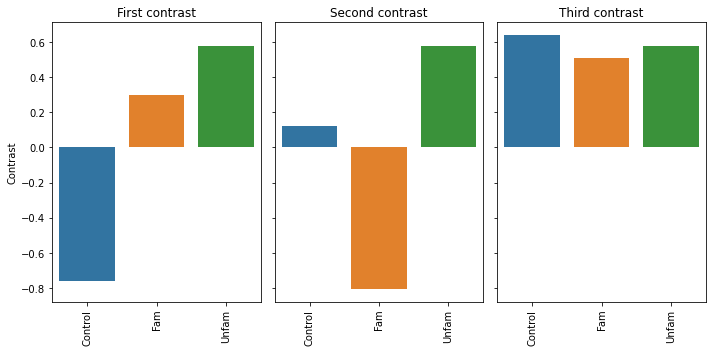

In [12]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.plot_contrasts(df_data=swiss_contrasts, index=0, ax=axes[0])
upls.plot_contrasts(df_data=swiss_contrasts, index=1, ax=axes[1])
upls.plot_contrasts(df_data=swiss_contrasts, index=2, ax=axes[2])
axes[0].set_ylabel('Contrast')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
for i in range(3):
    axes[i].set(xlabel=None)
plt.tight_layout()
plt.savefig('./results_pls/swiss_19-35-150_10-10_pls_contrasts_all_areas.png')
plt.savefig('./results_pls/swiss_19-35-150_10-10_pls_contrasts_all_areas.png')

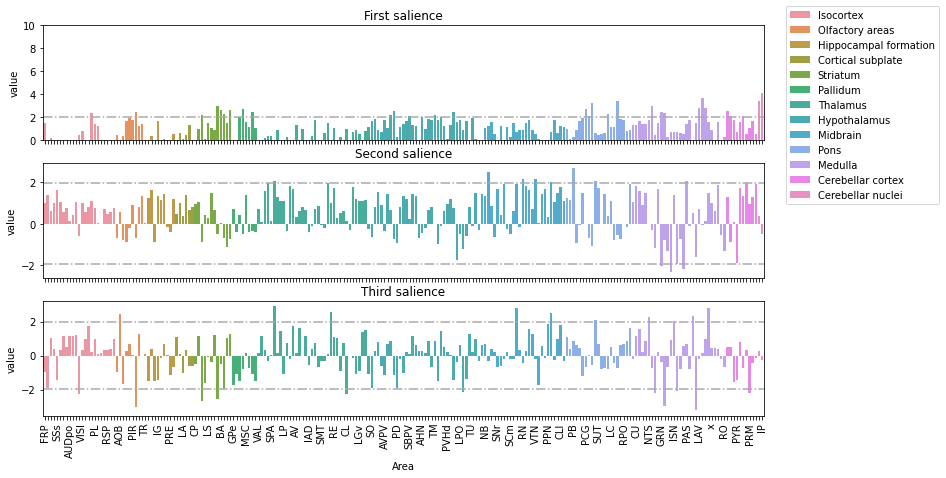

In [13]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,7))
plt.subplots_adjust(top=0.9, left=0.03, right=0.8)
upls.plot_saliences(df_data=swiss_saliences, index=0, ax=axes[0], df_levels=df_levels)
upls.plot_saliences(df_data=swiss_saliences, index=1, ax=axes[1], df_levels=df_levels)
upls.plot_saliences(df_data=swiss_saliences, index=2, ax=axes[2], df_levels=df_levels)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[0].set_ylim(0,10)
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
axes[0].legend(loc='right', bbox_to_anchor=(1.25,0.3))
axes[1].get_legend().remove()
axes[2].get_legend().remove()
n = 4  # Keeps every 7th label
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]
plt.savefig('./results_pls/swiss_19-35-150_10-10_pls_saliences_all_areas.png')
plt.savefig('./results_pls/swiss_19-35-150_10-10_pls_saliences_all_areas.svg')

# Identify areas with significant salience contribution

In [14]:
pls_sig_areas = upls.identify_pls_sig_areas(saliences=swiss_saliences, 
                                       threshold=1.96, 
                                       volumes=volumes)

In [15]:
pls_sig_areas

array(['Abducens nucleus', 'Accessory olfactory bulb',
       'Anterior amygdalar area', 'Anterior cingulate area',
       'Anterior hypothalamic nucleus', 'Anteromedial visual area',
       'Bed nuclei of the stria terminalis',
       'Bed nucleus of the accessory olfactory tract',
       'Central amygdalar nucleus',
       'Central lateral nucleus of the thalamus', 'Declive (VI)',
       'Dorsal premammillary nucleus', 'Facial motor nucleus',
       'Fastigial nucleus', 'Fundus of striatum',
       'Gigantocellular reticular nucleus',
       'Globus pallidus internal segment', 'Inferior salivatory nucleus',
       'Infracerebellar nucleus', 'Interfascicular nucleus raphe',
       'Intermediate reticular nucleus', 'Interposed nucleus',
       'Lateral vestibular nucleus', 'Linear nucleus of the medulla',
       'Lingula (I)', 'Magnocellular nucleus', 'Medial amygdalar nucleus',
       'Medial preoptic area', 'Medial vestibular nucleus',
       'Median preoptic nucleus', 'Nodulus (X)',

# Apply PLS for all significant areas in ncells and energy

In [16]:
# select significant areas
experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dict_results_across_mice.keys()))
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = upls.select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
# get corresponding acronyms of these areas
sig_acronyms = [volumes.loc[volumes['safe_name'] == area]['acronym'].values[0] for area in sig_areas_ncells_ttest]
# remove columns from database
keep_columns = ['subject', 'sex', 'group'] + sig_acronyms
# make database filtered
data_ncells_filt = data_ncells.drop(columns=[col for col in data_ncells if col not in keep_columns])
data_energy_filt = data_energy.drop(columns=[col for col in data_energy if col not in keep_columns])
data_ncells_filt.to_csv('./results_pls/'+batch+'-150_10-10_n_cells_filt.csv')
data_energy_filt.to_csv('./results_pls/'+batch+'-150_10-10_energy_filt.csv')

In [17]:
%%bash
python area_pls.py -i results_pls/SWISS_19-35-150_10-10_n_cells_filt.csv -o './results_pls/SWISS_19-35-150_10-10_filt'

2023-05-18 17:01:18 PC1QFRRQ __main__[75685] INFO reading data...
2023-05-18 17:01:18 PC1QFRRQ __main__[75685] INFO computing PLS...
2023-05-18 17:01:18 PC1QFRRQ __main__[75685] INFO PLS computed, now performing bootstrap...
2023-05-18 17:01:18 PC1QFRRQ __main__[75685] INFO saving output data...


In [18]:
%%bash
python area_pls.py -i results_pls/SWISS_19-35-150_10-10_energy_filt.csv -o './results_pls/SWISS_19-35-150_10-10_filt'

2023-05-18 17:01:20 PC1QFRRQ __main__[75691] INFO reading data...
2023-05-18 17:01:20 PC1QFRRQ __main__[75691] INFO computing PLS...
2023-05-18 17:01:20 PC1QFRRQ __main__[75691] INFO PLS computed, now performing bootstrap...
2023-05-18 17:01:20 PC1QFRRQ __main__[75691] INFO saving output data...


In [19]:
swiss_contrasts_filt = pd.read_csv('./results_pls/SWISS_19-35-150_10-10_filt_contrasts.csv')
swiss_saliences_filt = pd.read_csv('./results_pls/SWISS_19-35-150_10-10_filt_saliences.csv')
swiss_contrasts_filt.columns = ['Control', 'Fam', 'Unfam']

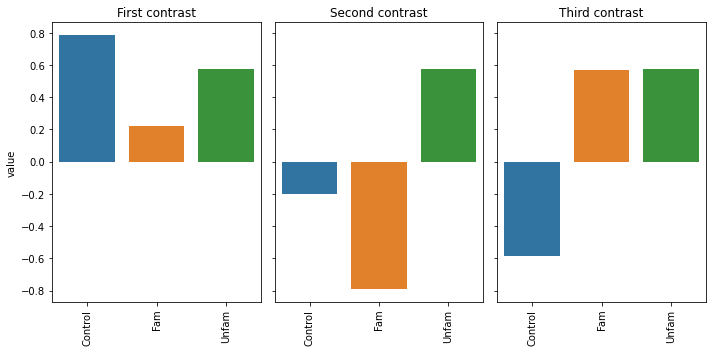

In [20]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.plot_contrasts(df_data=swiss_contrasts_filt, index=0, ax=axes[0])
upls.plot_contrasts(df_data=swiss_contrasts_filt, index=1, ax=axes[1])
upls.plot_contrasts(df_data=swiss_contrasts_filt, index=2, ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
for i in range(3):
    axes[i].set(xlabel=None)
plt.tight_layout()
plt.savefig('./results_pls/swiss_19-35-150_10-10_pls_contrasts_sig_areas.png')

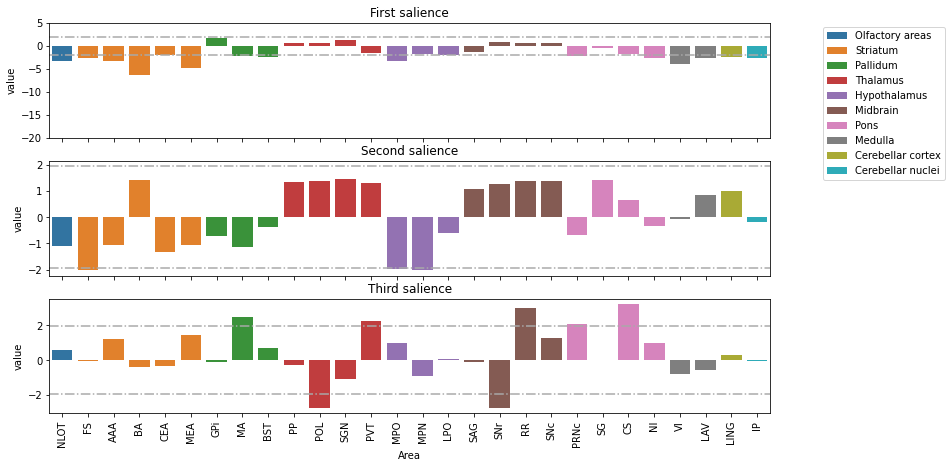

In [21]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,7))
plt.subplots_adjust(top=0.9, left=0.03, right=0.8)
upls.plot_saliences(df_data=swiss_saliences_filt, index=0, ax=axes[0], df_levels=df_levels)
upls.plot_saliences(df_data=swiss_saliences_filt, index=1, ax=axes[1], df_levels=df_levels)
upls.plot_saliences(df_data=swiss_saliences_filt, index=2, ax=axes[2], df_levels=df_levels)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[0].set_ylim(-20,5)
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
axes[0].legend(loc='right', bbox_to_anchor=(1.25,0.3))
axes[1].get_legend().remove()
axes[2].get_legend().remove()
n = 4  # Keeps every 7th label
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
plt.savefig('./results_pls/swiss_pls_150_10-10_saliences_sig_areas.png')
plt.savefig('./results_pls/swiss_pls_150_10-10_saliences_sig_areas.svg')

# Identify areas with significant salience contribution

In [22]:
pls_sig_areas_filt = upls.identify_pls_sig_areas(saliences=swiss_saliences_filt, 
                                       threshold=1.96, 
                                       volumes=volumes)
pls_sig_areas_filt

array(['Abducens nucleus', 'Anterior amygdalar area',
       'Bed nuclei of the stria terminalis',
       'Bed nucleus of the accessory olfactory tract',
       'Central amygdalar nucleus', 'Fundus of striatum',
       'Interposed nucleus', 'Lateral vestibular nucleus', 'Lingula (I)',
       'Magnocellular nucleus', 'Medial amygdalar nucleus',
       'Medial preoptic area', 'Medial preoptic nucleus',
       'Midbrain reticular nucleus retrorubral area', 'Nucleus incertus',
       'Nucleus of the lateral olfactory tract',
       'Paraventricular nucleus of the thalamus',
       'Pontine reticular nucleus caudal part',
       'Posterior limiting nucleus of the thalamus',
       'Substantia nigra reticular part',
       'Superior central nucleus raphe'], dtype='<U44')